**task 1**

**findings:**
- users who stayed tend to have short connection time
- there were users who paid but never matched
- more organic than inorgan users, and organic users are relatively less likely to churn
- inorganic users are more likely to churn, but the churn rate is not too bad, showing stickiness to the app
- application platform does not affect user churn, meaning neither desktop or mobile is affecting churn
- in general, therapist replied more words than clients, but simply more words from therapist do not determine if a user would churn

**recommendations:**
- increase connection time, either through hiring more therapist or find a way to engage client better
- inorganic users are sticky, meaning the app is delivering users' expectation
- mobile platform is the top choice for users, continuous investment is needed

**next steps:**
- figure out why there were users never matched (is it a database problem?)
- dive deeper into each acquisition channel to see if there is one that is more likely to make a user churn
- analyze the content of the conversation through NLP rather than simply counting the number of words being exchanged
- observe the time and date of the observation, and see if that makes a difference
- differentiate user churn during different app updates/versions
- tune the current decision trees with more features and build other predictive models
- more data to build a user profile: occupation, income level, ethnicity, location, hobby, etc.

**task2**

**building predictive model to identify likelihood to purchase subscription:**

- method: 
    - identify current users who purchased subscription
    - capture their jounery between signing up and purchasing subscription, with features such as:
        - current data:
            - length took before being matched
            - timespent on the app before purchasing subscription
        - other data needed:
            - the therapist matched
            - time of the day when they signed up for the app 
            - do they click certain features more when they first started using the app
    - run predictive modeling:
        - bayesian networks: understand which feature(s) drives subcription probability
        - tree-based model: understand which feature(s) play an important role in driving subscription
        - GLM: understand which feature(s) could help explain subscription
    - a/b testing:
        - use model that gave good predictive power and explanability for business users
        - run a/b testing by nudging the users towards features that the model thinks are driving subscription
     - conclusion and repeat:
         - analyze if the model chosen above is helping subscription
         - if failed, think of ways for obtaining more data, include surveys for current users (user research)

In [15]:
#import all packages 
import sqlite3
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

**Load Files**

In [2]:
#read files from database
db_name = "TS_datascience_exercise_data.db"

client_info_query = 'SELECT * FROM client_info;'
client_info_columns = ['client_id', 'presenting_issue_id', 'gender', 'age_range', 'marketing_source']

client_lifecycle_query = 'SELECT * FROM client_lifecycle;'
client_lifecycle_columns = ['client_id', 'lead_capture_date', 'purchase_date', 'match_date', 'cancelation_date']

client_activity_query = 'SELECT * FROM client_activity;'
client_activity_columns = ['message_id', 'client_id', 'send_time', 'sender_type', 'message_type', 'word_count', 'device_type']

#establish database connection
def create_tb_from_db(db_name, query, column_names):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()
    data = cursor.execute(query).fetchall()  
    df = pd.DataFrame(list(data), columns=column_names)
    connection.close() 
    return(df)

#create tables from database
client_info_tb = create_tb_from_db(db_name, client_info_query, client_info_columns)
client_lifecycle_tb = create_tb_from_db(db_name, client_lifecycle_query, client_lifecycle_columns)
client_activity_tb = create_tb_from_db(db_name, client_activity_query, client_activity_columns)

**EDA**

In [3]:
#data overview
print('info_table:', client_info_tb.head(2))
print('lifecyle_table:', client_lifecycle_tb.head(2))
print('activity_table:', client_activity_tb.head(2))

#understand the time scope of the data
print('last_activity:', max(client_activity_tb.send_time)) #2019-04-30
print('last_activity:', min(client_activity_tb.send_time)) #2018-06-01

###identify churn: clients whose cancelation date is None and have purchase date
#change string into datetime
client_lifecycle_tb.iloc[:, 1:] = client_lifecycle_tb.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

#elimate non-paid users, and retain only users who ever paid
paid_users = client_lifecycle_tb[client_lifecycle_tb['purchase_date'].notnull()].reset_index(drop = True)
print('number of total paid users: ', paid_users.shape[0]) # 4089 users

#users who paid and stayed
stayed_users = paid_users[paid_users['cancelation_date'].isnull()].reset_index(drop = True)
stayed_users['churned']=0 #new column with value 0 for users who stayed
print('number of users who stayed: ',stayed_users.shape[0]) #1334 users

#users who paid and churned
churned_users = paid_users[paid_users['cancelation_date'].notnull()].reset_index(drop = True)
churned_users['churned']=1 #new column with value 1 for users who left
print('number of users who left: ',churned_users.shape[0]) #2755 users

info_table:    client_id  presenting_issue_id gender age_range  marketing_source
0   11429734                  NaN   None      None       Paid Social
1   11429773                  NaN   None      None  Organic (Direct)
lifecyle_table:    client_id    lead_capture_date purchase_date match_date cancelation_date
0   11429734  2018-05-31 09:46:12          None       None             None
1   11429773  2018-05-31 07:43:38          None       None             None
activity_table:    message_id  client_id            send_time sender_type message_type  \
0    33830737   11429734  2018-06-01 01:05:37   therapist         chat   
1    33831102   11429773  2018-06-01 01:13:56      client         chat   

   word_count device_type  
0        93.0      mobile  
1         2.0         web  
last_activity: 2019-04-30 23:52:05
last_activity: 2018-06-01 01:05:37
number of total paid users:  4089
number of users who stayed:  1334
number of users who left:  2755


**churned users**

In [4]:
#identify churned users:
user_tbl = pd.concat([churned_users, stayed_users]).reset_index(drop=True) #table with users for analytics
user_tbl.head()

**Identify potential features to be used for preliminary descriptive analysis:**

1. marketing source from client_info_db: inorganic might have higher churn
2. time difference between purchase date and match date from user_tbl: long lapse between matching could lead to churn \
3. word_count difference from client_activity_tb: shorter words reply from therapist could lead to churn
4. device_type from client_activity_tb: some platform might have worse experience that could lead to churn

 
**Future descriptive analysis:**
1. exchange frequency between client and therapist
2. dive deeper into each acquisition channel to see if how effective each channel is
3. check each message_id with nlp to see if a paticular topic is effecting churn

**time took to match users:**
- conclusion: users who stayed tend to get connect faster than user who churned
- business action: incrase connection time: hire more theapist or find ways to keep user engaged

In [6]:
#time difference between purchase date and match date from user_tbl: 
user_tbl['time_between_matching'] =user_tbl.apply(lambda row: row['match_date'] - row['purchase_date'], axis=1)

print('median time of churned users took to match: {}'.\
      format(user_tbl[user_tbl['churned'] == 1].time_between_matching.median()))

print('median time of stayed users took to match: {}'.\
      format(user_tbl[user_tbl['churned'] == 0].time_between_matching.median()))

#conclusion: users who stayed tend to get connect faster than user who churned
#business action: incrase connection time: hire more theapist or find ways to keep user engaged

median time of churned users took to match: 0 days 08:27:28
median time of stayed users took to match: 0 days 06:13:49


**users who were never matched:**
- conclusion: interesting finding that there are users who paid and stayed but never matched.
- business action: Could be a database problem. If not, needs to dig deeper.

In [7]:
#ratio of users who churned and were never matched:
print('ratio of users who churned and were never matched: {}'.\
      format(
user_tbl[(user_tbl['churned'] == 1) & (user_tbl['time_between_matching'].isnull())].shape[0] / churned_users.shape[0]))

#ratio of users who stayed and were never matched:
print('ratio of users who stayed and were never matched: {}'.\
      format(
user_tbl[(user_tbl['churned'] == 0) & (user_tbl['time_between_matching'].isnull())].shape[0] / stayed_users.shape[0]))

#conclusion: interesting finding that there are users who paid and stayed but never matched. Could be a database problem. If not, dig deeper.

ratio of users who churned and were never matched: 0.025408348457350273
ratio of users who stayed and were never matched: 0.043478260869565216


**organic vs inorganic user:**
- conclusion: there are more organic user than inorganic users, and churned users have higher ratio to be inorganic
- business action: seek ways to increase organic growing, but the number also shows inorganic users who relatively sticky

In [8]:
#check distribution of acquisition channels
client_info_tb['marketing_source'].value_counts()

#create table merged between user_tbl and client_info_tb
user_info_tbl = pd.merge(user_tbl, client_info_tb, on='client_id', how='left')

#change marketing_source into str
user_info_tbl.marketing_source = user_info_tbl.marketing_source.apply(str)

#create new column if a user is organic, assume a user if organic if it is nan
user_info_tbl['organic'] = user_info_tbl.apply(lambda x: 1 if 'Organic' in x['marketing_source'] else ( 1 if  x['marketing_source']=='nan' else 0), axis=1)

#count organic and inorganic users
inorganic_user_count = user_info_tbl[user_info_tbl['organic'] == 0].shape[0]
organic_user_count = user_info_tbl[user_info_tbl['organic'] == 1].shape[0]
print('organic_users: ', organic_user_count)
print('inorganic_users: ', inorganic_user_count)

#ratio of churned users who were inorganic:
print('ratio of churned users who were inorganic:{}'.\
      format(
user_info_tbl[(user_info_tbl['churned'] == 1) & (user_info_tbl['organic'] == 0)].shape[0] / churned_users.shape[0]))

#ratio of stayed users who were inorganic:
print('ratio of stayed users who were inorganic: {}'.\
      format(
user_info_tbl[(user_info_tbl['churned'] == 0) & (user_info_tbl['organic'] == 0)].shape[0] / stayed_users.shape[0]))

#conclusion: user who stayed have less inorganic than user who churned. In another words, user who stayed are a bit more likely to come from organic channels

organic_users:  2359
inorganic_users:  1730
ratio of churned users who were inorganic:0.43920145190562615
ratio of stayed users who were inorganic: 0.38980509745127434


**words traded between client and therapist**
- conclusion: not a significant difference in terms of total number of words replied from therapist because both stayed and churned users heard back from from therapist
- business action: dive deeper into the quality of conversation

In [9]:
##create clients words count
client_words_tb = client_activity_tb[client_activity_tb['sender_type'] == 'client'].groupby('client_id') \
.sum()['word_count'].reset_index().rename(columns={'word_count':'client_word_count'})

#create therapist words count
therapist_words_tb = client_activity_tb[client_activity_tb['sender_type'] == 'therapist'].groupby('client_id') \
.sum()['word_count'].reset_index().rename(columns={'word_count':'therapist_word_count'})

#create client_therapist_words_tbl and calculate words difference:
client_therapist_words_tbl = pd.merge(client_words_tb, therapist_words_tb, on='client_id', how='outer')

client_therapist_words_tbl[['client_word_count', 'therapist_word_count']] = client_therapist_words_tbl[['client_word_count', 'therapist_word_count']].fillna(0)

client_therapist_words_tbl['client_more_words'] =client_therapist_words_tbl.apply \
(lambda row: row['client_word_count'] - row['therapist_word_count'], axis=1)

#merge words diff table with user_info_tbl: 
user_info_words_tbl = pd.merge(user_info_tbl, client_therapist_words_tbl, on='client_id', how='left')
user_info_words_tbl[['client_word_count', 'therapist_word_count', 'client_more_words']] = user_info_words_tbl[['client_word_count', 'therapist_word_count', 'client_more_words']].fillna(0)

#check if user who churned spoke more than therapist
print('median words for churned users where client spoke more than therapist: {}'.\
      format(user_info_words_tbl[user_info_words_tbl['churned'] == 1].client_more_words.median()))

print('median words for stayed users where client spoke more than therapist: {}'.\
      format(user_info_words_tbl[user_info_words_tbl['churned'] == 0].client_more_words.median()))

#conclusion: not a significant difference in terms of words replied from therapist because both stayed and churned heard back from from therapist

median words for churned users where client spoke more than therapist: -78.0
median words for stayed users where client spoke more than therapist: -62.5


**device type vs churn**
- conclusion: most of the users use mobile platform, thus it cannot be concluded that users would leave because they had a bad experience due to platform
- business action: mobile platform is the top choice for users, thus investment in mobile is important

In [10]:
#device_type from client_activity_tb: some platform might have worse experience that could lead to churn

#check distribution of platform
client_activity_tb['device_type'].value_counts()

#mobile/web ratio for each user
client_mobile_tbl = client_activity_tb[(client_activity_tb['device_type'] == 'mobile') & (client_activity_tb['sender_type'] == 'client')] \
.groupby('client_id').count()['device_type'].reset_index().rename(columns={'device_type': 'mobile_device_type_count'})

#mobile/web ratio for each user
client_web_tbl = client_activity_tb[(client_activity_tb['device_type'] == 'web') & (client_activity_tb['sender_type'] == 'client')] \
.groupby('client_id').count()['device_type'].reset_index().rename(columns={'device_type': 'web_device_type_count'})

#mobile/web ratio for each user
client_web_mobile_total_tbl = client_activity_tb[client_activity_tb['sender_type'] == 'client'] \
.groupby('client_id').count()['device_type'].reset_index().rename(columns={'device_type': 'total_device_type_count'})

#find the mobile/mobile+web ratio for each user
web_mobile_dist = pd.merge(client_mobile_tbl, client_web_tbl, on='client_id', how='outer')
web_mobile_tbl = pd.merge(web_mobile_dist, client_web_mobile_total_tbl, on='client_id', how='outer')

web_mobile_tbl[['web_device_type_count', 'mobile_device_type_count', 'total_device_type_count']] = web_mobile_tbl[['web_device_type_count', 'mobile_device_type_count', 'total_device_type_count']].fillna(0)

#calculate mobile_ratio
web_mobile_tbl['mobile_ratio'] = web_mobile_tbl.apply(lambda row: row['mobile_device_type_count'] / row['total_device_type_count'], axis=1)

user_info_words_mobile_tbl = pd.merge(user_info_words_tbl, web_mobile_tbl, on='client_id', how='left')
user_info_words_mobile_tbl[['web_device_type_count', 'mobile_device_type_count', 'total_device_type_count']] = user_info_words_mobile_tbl[['web_device_type_count', 'mobile_device_type_count', 'total_device_type_count']].fillna(0)

#calculate median mobile ratio for churned and stayed users:
print('median mobile ratio for churned users: {}'.\
      format(user_info_words_mobile_tbl[user_info_words_mobile_tbl['churned'] == 1].mobile_ratio.median()))

print('median mobile ratio for stayed users: {}'.\
      format(user_info_words_mobile_tbl[user_info_words_mobile_tbl['churned'] == 0].mobile_ratio.median()))

#conclusion: most of the users use mobile platform, thus it cannot be concluded that users would leave because they had a bad experience due to platform

median mobile ratio for churned users: 0.9725399019731055
median mobile ratio for stayed users: 0.9790524237771441


**Decision Tree**
- needs further tuning to arrive at any conclusion

In [11]:
###build a quick decision tree for business users
#dummify value for presenting_issue_id
user_info_words_mobile_tbl['presenting_issue_id'] = user_info_words_mobile_tbl['presenting_issue_id'].fillna(0)
user_info_words_mobile_tbl['with_issue_presented'] = user_info_words_mobile_tbl.apply(lambda x: 1 if x.presenting_issue_id != 0 else 0, axis=1)

#dummify categorical values

dummified_columns = pd.get_dummies(user_info_words_mobile_tbl[["gender", "age_range", "marketing_source"]],dummy_na=True) 

#join dummified value back into table
user_info_words_mobile_tbl=user_info_words_mobile_tbl.join(dummified_columns)

#convert timestamp of timedealta into seconds
user_info_words_mobile_tbl['time_between_matching'] = user_info_words_mobile_tbl.apply(lambda row: row['time_between_matching'].total_seconds(), axis =1)

#fill mobile ratio as 0 for nan
user_info_words_mobile_tbl['mobile_ratio'] = user_info_words_mobile_tbl['mobile_ratio'].fillna(0)

# #drop original columns and timestamp since they have been dumified already
drop_columns = ["lead_capture_date", "purchase_date", "match_date", "cancelation_date", "client_id", "gender", "age_range", "marketing_source", "presenting_issue_id"]
user_info_words_mobile_tree_prep_tbl = user_info_words_mobile_tbl.drop(drop_columns, axis = 1)



original length:  4089
filtered length:  3961
f1 score:  0.8043310131477185


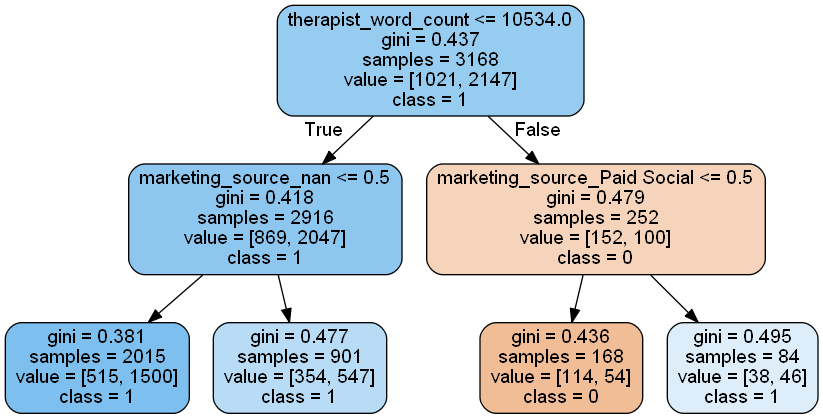

In [12]:
###start building decision tree
#check dataset length without na values:
print('original length: ', user_info_words_mobile_tree_prep_tbl.shape[0])
print('filtered length: ', user_info_words_mobile_tree_prep_tbl[user_info_words_mobile_tree_prep_tbl.apply(lambda x: sum(x.isnull().values), axis = 1)==0].shape[0])

#dataset for decision tree
user_info_words_mobile_tree_prep_filtered_tbl = user_info_words_mobile_tree_prep_tbl[user_info_words_mobile_tree_prep_tbl.apply(lambda x: sum(x.isnull().values), axis = 1)==0]

#prep train test split
X_train, X_test, y_train, y_test = train_test_split(
    user_info_words_mobile_tree_prep_filtered_tbl.drop('churned', axis=1), 
    user_info_words_mobile_tree_prep_filtered_tbl['churned'], test_size=0.2, random_state=0, stratify=user_info_words_mobile_tree_prep_filtered_tbl['churned'].values)

tree_model = tree.DecisionTreeClassifier(max_depth=2, criterion='gini', min_samples_leaf=2)

tree_model.fit(X_train, y_train)

y_predict = tree_model.predict(X_test)

print('f1 score: ', f1_score(y_test, y_predict))

#conda install python-graphviz
dot_graph_name = 'decision_tree.dot'
png_graph_name = 'decision_tree.png'
tree.export_graphviz(tree_model,out_file = dot_graph_name,
                    feature_names=X_train.columns, 
                     class_names=['0','1'],
                    filled=True, rounded=True ) 

#!dot -Tpng try_graph.dot -o try_graph.png
#type graph name below
!dot -Tpng decision_tree.dot -o decision_tree.png

from IPython.display import Image
Image(filename=png_graph_name)